In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/cleaned/final_data.csv')

In [3]:
# Drop unnecessary cols
df.drop(['begin_date', 'end_date', 'fips', 'parish', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
        'injuries_direct', 'injuries_indirect', 'deaths_direct', 'deaths_indirect', 'damage_property'],
        axis=1, inplace=True)
# Drop Coastal Flood -- too different from other floods and not enough sample size
df.drop('event_type_Coastal_Flood', axis=1, inplace=True)

In [4]:
df['is_flood'] = np.where(df.event_type_None == 1, 0, 1)
df.drop(['event_type_Flash_Flood', 'event_type_Flood', 'event_type_None'],
       axis=1, inplace=True)

In [5]:
df.head()

,avg_wind_spd,prcp,max_temp,min_temp,fastest_2m_wind_spd,fastest_5s_wind_spd,prev_7d_prcp,region_Central,region_Northeast,region_Northwest,region_Southeast,region_Southwest,season_fall,season_spring,season_summer,season_winter,is_flood
0,4.47,0.045,82.5,62.5,12.1,18.1,0.015,0,0,1,0,0,1,0,0,0,0
1,10.29,0.000,83.0,71.0,19.9,23.0,3.140,0,0,0,0,1,0,1,0,0,0
2,3.80,0.000,54.0,27.0,14.1,16.1,1.100,0,0,1,0,0,0,0,0,1,0
3,11.63,0.630,46.0,39.0,17.9,23.9,9.740,0,0,0,0,1,0,0,0,1,0
4,6.04,0.000,64.5,43.5,14.1,17.9,1.160,0,0,0,1,0,1,0,0,0,0


In [6]:
X = df.drop('is_flood', axis=1)
y = df['is_flood']

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=18, stratify=y)

print(f'Training set: ({len(X_train)}, {len(y_train)})')
print(f'Test set: ({len(X_test)}, {len(y_test)})')

Training set: (4347, 4347)
Test set: (1450, 1450)


In [8]:
# Stratification test
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.8601334253508166
0.86


# Logistic Regression

In [9]:
logreg = LogisticRegressionCV(cv=5, scoring='roc_auc', max_iter=1000, random_state=18)
logreg.fit(X_train, y_train)
print(f'Training score: {logreg.score(X_train, y_train)}')
print(f'Testing score: {logreg.score(X_test, y_test)}')

Training score: 0.9574937360115989
Testing score: 0.9696730280752625


### Use MinMaxScaler and compare performance

In [10]:
continuous_cols = ['avg_wind_spd', 'prcp', 'max_temp', 'min_temp', 'fastest_2m_wind_spd',
                   'fastest_5s_wind_spd', 'prev_7d_prcp']
categorical_cols = ['region_Central', 'region_Northeast', 'region_Northwest', 'region_Southeast',
                    'region_Southwest', 'season_fall', 'season_spring', 'season_summer', 'season_winter']

In [11]:
min_max = MinMaxScaler()

# Use MinMaxScaler to transform data
X_train_minmax = min_max.fit_transform(X_train[continuous_cols])
X_test_minmax = min_max.fit_transform(X_test[continuous_cols]) 

In [12]:
# TRAINING DATA
# Take categorical data
X_train_cat = X_train[categorical_cols].reset_index(drop=True)
# Convert transformed data to DataFrame
X_train_minmax = pd.DataFrame(X_train_minmax, columns=continuous_cols)
# Concat the two DataFrames
X_train_minmax = pd.concat([X_train_minmax, X_train_cat], sort=False, axis=1)

# TEST DATA
# Take categorical data
X_test_cat = X_test[categorical_cols].reset_index(drop=True)
# Convert transformed data to DataFrame
X_test_minmax = pd.DataFrame(X_test_minmax, columns=continuous_cols)
# Concat the two DataFrames
X_test_minmax = pd.concat([X_test_minmax, X_test_cat], sort=False, axis=1)

In [13]:
# Logistic Regression model for MinMaxScaled data
logreg = LogisticRegressionCV(cv=5, scoring='roc_auc', max_iter=1000, random_state=18)
logreg.fit(X_train_minmax, y_train)

print(f'Training score: {logreg.score(X_train_minmax, y_train)}')
print(f'Testing score: {logreg.score(X_test_minmax, y_test)}')

Training score: 0.9577545888993679
Testing score: 0.9695861199884649


**RESULTS:** MinMaxScaler data did not increase performance.

### Use sklearn.preprocessing.scale and compare performance

In [14]:
# Use scale to transform data
X_train_scale = scale(X_train[continuous_cols])
X_test_scale = scale(X_test[continuous_cols])

# TRAINING DATA
# Convert transformed data to DataFrame
X_train_scale = pd.DataFrame(X_train_scale, columns=continuous_cols)
# Concat the two DataFrames
X_train_scale = pd.concat([X_train_scale, X_train_cat], sort=False, axis=1)

# TEST DATA
# Convert transformed data to DataFrame
X_test_scale = pd.DataFrame(X_test_scale, columns=continuous_cols)
# Concat the two DataFrames
X_test_scale = pd.concat([X_test_scale, X_test_cat], sort=False, axis=1)

In [15]:
# Logistic regression on scaled data
logreg = LogisticRegressionCV(cv=5, scoring='roc_auc', max_iter=1000)
logreg.fit(X_train_scale, y_train)

print(f'Training score: {logreg.score(X_train_scale, y_train)}')
print(f'Testing score: {logreg.score(X_test_scale, y_test)}')

Training score: 0.9574822989541252
Testing score: 0.969665127340099


**RESULTS:** sklearn.preprocessing.scale data did not increase performance.

## Hyperparameter Tuning

In [16]:
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [17]:
logreg = LogisticRegression(random_state=18)
gs_logreg = GridSearchCV(logreg, cv=5,
                         param_grid=hyperparameters,
                         scoring='roc_auc')
best_logreg = gs_logreg.fit(X_train, y_train) 

print(f'Best score: {best_logreg.best_score_}') 
print(f'Best parameters: {best_logreg.best_params_}')

Best score: 0.9560967757648957
Best parameters: {'C': 59.94842503189409, 'penalty': 'l2'}


## Thresholding and ROC Curve

In [18]:
# Calculate predicted probabilities
y_pred_prob_logreg = best_logreg.predict_proba(X_test)[:, 1]
# Generate ROC-AUC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg)

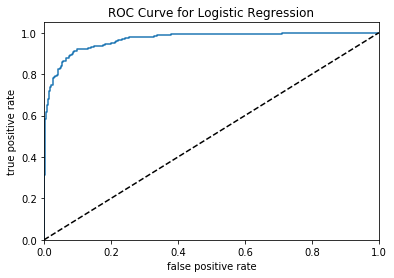

In [19]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve for Logistic Regression')
plt.savefig('../docs/img/roc-logreg.png', dpi=300, bbox_inches='tight');

In [20]:
print(f'ROC-AUC score for Logistic Regression: {roc_auc_score(y_test, y_pred_prob_logreg)}')

ROC-AUC score for Logistic Regression: 0.9676425391382668


In [21]:
best_threshold_logreg, best_score_logreg = -1, -1
fbetas = []
for threshold in thresholds:
    y_thresh = y_pred_prob_logreg > threshold
    # We are optimizing for recall - correctly classifying true flood events
    # beta = 2 minimizes false negatives
    fbeta = fbeta_score(y_test, y_thresh, beta=2)
    fbetas.append(fbeta)
    if fbeta > best_score_logreg:
        best_threshold_logreg = threshold
        best_score_logreg = fbeta

best_threshold_logreg, best_score_logreg

(0.10633073073902519, 0.832579185520362)

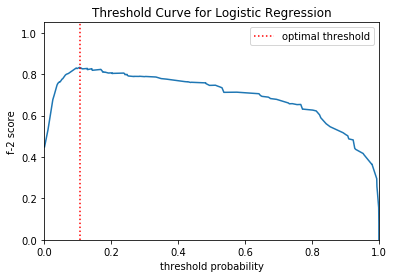

In [22]:
plt.plot(thresholds, fbetas)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('threshold probability')
plt.ylabel('f-2 score')
plt.axvline(best_threshold_logreg, color='red', linestyle=':',
            label='optimal threshold')
plt.legend()
plt.title('Threshold Curve for Logistic Regression')
plt.savefig('../docs/img/threshold-logreg.png', dpi=300, bbox_inches='tight');

In [23]:
y_pred = y_pred_prob_logreg > best_threshold_logreg
y_pred = y_pred.astype(int)

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['no flood', 'flood'],
             index=['no flood', 'flood'])

Confusion Matrix:


,no flood,flood
no flood,1138,109
flood,19,184


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1247
           1       0.63      0.91      0.74       203

    accuracy                           0.91      1450
   macro avg       0.81      0.91      0.84      1450
weighted avg       0.93      0.91      0.92      1450



# Random Forest

In [25]:
rf = RandomForestClassifier(random_state=18)
rf.fit(X_train, y_train) 

print(f'Training score: {rf.score(X_train, y_train)}')
print(f'Testing score: {rf.score(X_test, y_test)}')

Training score: 1.0
Testing score: 0.9503448275862069


### Compare performance of MinMaxScaler data

In [26]:
rf = RandomForestClassifier(random_state=18)
rf.fit(X_train_minmax, y_train) 

print(f'Training score: {rf.score(X_train_minmax, y_train)}')
print(f'Testing score: {rf.score(X_test_minmax, y_test)}')

Training score: 1.0
Testing score: 0.9448275862068966


**RESULTS:** MinMaxScaler did not increase performance.

### Compare performance of sklearn.preprocessing.scale data

In [27]:
rf = RandomForestClassifier(random_state=18)
rf.fit(X_train_scale, y_train) 

print(f'Training score: {rf.score(X_train_scale, y_train)}')
print(f'Testing score: {rf.score(X_test_scale, y_test)}')

Training score: 1.0
Testing score: 0.9496551724137932


**RESULTS:** sklearn.preprocessing.scale did not increase performance.

## Hyperparameter Tuning

In [28]:
hyperparameters = {'min_samples_split': [0.001, 0.01, 0.1],
                   'min_samples_leaf': [0.001, 0.01, 0.1, 1]}

In [29]:
rf = RandomForestClassifier(random_state=18)
gs_rf = GridSearchCV(rf, cv=5,
                     param_grid=hyperparameters,
                     scoring='roc_auc')
best_rf = gs_rf.fit(X_train, y_train) 

print(f'Best score: {best_rf.best_score_}')
print(f'Best parameters: {best_rf.best_params_}')

Best score: 0.9648596413067168
Best parameters: {'min_samples_leaf': 0.001, 'min_samples_split': 0.001}


In [30]:
params = best_rf.best_params_
rf = RandomForestClassifier(random_state=18,
                            min_samples_leaf=params['min_samples_leaf'],
                            min_samples_split=params['min_samples_split'])
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=0.001,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=18, verbose=0,
                       warm_start=False)

## Thresholding and ROC Curve

In [31]:
# Calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
# Generate ROC-AUC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

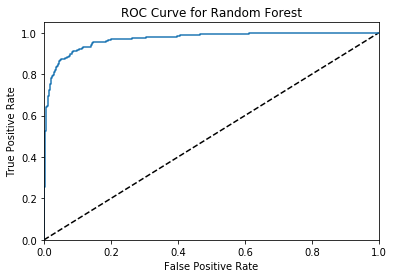

In [32]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.savefig('../docs/img/roc-rf.png', dpi=300, bbox_inches='tight');

In [33]:
print(f'ROC-AUC Score for Random Forest: {roc_auc_score(y_test, y_pred_prob_rf)}')

ROC-AUC Score for Random Forest: 0.9696414251346088


In [34]:
best_threshold_rf, best_score_rf = -1, -1
fbetas_rf = []
for threshold in thresholds:
    y_thresh = y_pred_prob_rf > threshold
    # We are optimizing for recall - correctly classifying true flood events
    # beta = 2 minimizes false negatives
    fbeta = fbeta_score(y_test, y_thresh, beta=2)
    fbetas_rf.append(fbeta)
    if fbeta > best_score_rf:
        best_threshold_rf = threshold
        best_score_rf = fbeta

best_threshold_rf, best_score_rf

(0.24113474025974027, 0.8388941849380362)

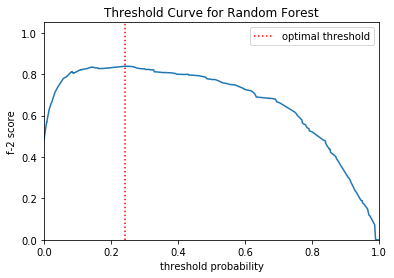

In [35]:
plt.plot(thresholds, fbetas_rf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('threshold probability')
plt.ylabel('f-2 score')
plt.axvline(best_threshold_rf, color='red', linestyle=':',
            label='optimal threshold')
plt.legend()
plt.title('Threshold Curve for Random Forest')
plt.savefig('../docs/img/threshold-rf.png', dpi=300, bbox_inches='tight');

In [36]:
y_pred_rf = y_pred_prob_rf > best_threshold_rf
y_pred = y_pred.astype(int)

print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
             columns=['no flood', 'flood'],
             index=['no flood', 'flood'])

Confusion Matrix:


,no flood,flood
no flood,1186,61
flood,27,176


In [37]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1247
           1       0.74      0.87      0.80       203

    accuracy                           0.94      1450
   macro avg       0.86      0.91      0.88      1450
weighted avg       0.94      0.94      0.94      1450



In [38]:
# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']) \
    .sort_values('importance', ascending=False)

feature_importances

,importance
prcp,0.609939
fastest_5s_wind_spd,0.083818
fastest_2m_wind_spd,0.074997
prev_7d_prcp,0.066977
min_temp,0.042080
max_temp,0.041285
avg_wind_spd,0.033122
region_Northwest,0.021002
region_Southeast,0.005733
season_summer,0.004819


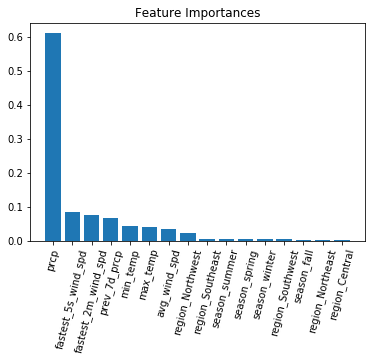

In [39]:
plt.bar(feature_importances.index, feature_importances.importance)
plt.xticks(rotation=76)
plt.title('Feature Importances')
plt.savefig('../docs/img/feature-importances.png', dpi=300, bbox_inches='tight');

## In terms of our business decision of optimizing for recall, the random forest performed the best with f2 score = 0.839 vs. logistic regression f2 score = 0.836.